In [37]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

In [38]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

def load_data(data_dir, img_size=(128, 128)):
    X = []
    y = []
    for label in ['NORMAL', 'PNEUMONIA']:
        label_dir = os.path.join(data_dir, label)
        for img_name in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:  # Ensure the image loaded successfully
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(1 if label == 'PNEUMONIA' else 0)
            else:
                print(f"Warning: Could not read image {img_path}")
    X = np.array(X) / 255.0  # Normalize pixel values to 0-1
    y = np.array(y)
    return X, y

# Load data
data_dir = 'C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection'
X, y = load_data(data_dir)
X = X.reshape(-1, 128, 128, 1)  # Add channel dimension


In [39]:
# Check pixel value range
print("Minimum pixel value:", X.min())
print("Maximum pixel value:", X.max())


Minimum pixel value: 0.0
Maximum pixel value: 1.0


Label Distribution:
 1    4265
0    1575
Name: Label, dtype: int64
Imbalance Ratio (Pneumonia/Normal): 2.71


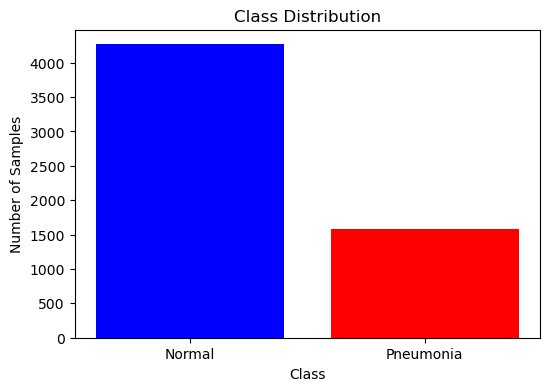

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert labels to a DataFrame for easier visualization and counting
labels_df = pd.DataFrame(y, columns=['Label'])

# Count the occurrences of each class
label_counts = labels_df['Label'].value_counts()
print("Label Distribution:\n", label_counts)

# Check the imbalance ratio
normal_count = label_counts[0]
pneumonia_count = label_counts[1]
imbalance_ratio = pneumonia_count / normal_count if normal_count > 0 else 0
print(f"Imbalance Ratio (Pneumonia/Normal): {imbalance_ratio:.2f}")

# Visualize the distribution
plt.figure(figsize=(6, 4))
plt.bar(['Normal', 'Pneumonia'], label_counts, color=['blue', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()


Imbalanced dataset

In [41]:
# First, split into train+val and test sets (85% train+val, 15% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Then split train+val into separate training and validation sets (70% train, 15% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  # 0.1765 * 0.85 ≈ 0.15


In [42]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


In [44]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam



# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Adjust class weights to balance them further 

balanced_class_weights = {
    0: 1.5,  
    1: 1.0   
}

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=balanced_class_weights,  # Apply class weights
    callbacks=[early_stopping]
)


Epoch 1/20
128/128 [==============================] - 97s 677ms/step - loss: 0.7396 - accuracy: 0.8840 - val_loss: 5.6836 - val_accuracy: 0.7229
Epoch 2/20
128/128 [==============================] - 96s 750ms/step - loss: 0.2571 - accuracy: 0.9180 - val_loss: 11.1044 - val_accuracy: 0.7229
Epoch 3/20
128/128 [==============================] - 89s 700ms/step - loss: 0.2085 - accuracy: 0.9300 - val_loss: 4.2628 - val_accuracy: 0.7229
Epoch 4/20
128/128 [==============================] - 95s 740ms/step - loss: 0.2016 - accuracy: 0.9425 - val_loss: 5.3655 - val_accuracy: 0.7229
Epoch 5/20
128/128 [==============================] - 82s 644ms/step - loss: 0.1768 - accuracy: 0.9454 - val_loss: 0.1806 - val_accuracy: 0.9453
Epoch 6/20
128/128 [==============================] - 78s 605ms/step - loss: 0.1596 - accuracy: 0.9550 - val_loss: 0.1488 - val_accuracy: 0.9510
Epoch 7/20
128/128 [==============================] - 77s 601ms/step - loss: 0.1371 - accuracy: 0.9518 - val_loss: 0.4716 - val_a

28/28 [==============================] - 4s 122ms/step - loss: 0.1421 - accuracy: 0.9532
Validation Loss: 0.14206235110759735
Validation Accuracy: 0.9532496929168701


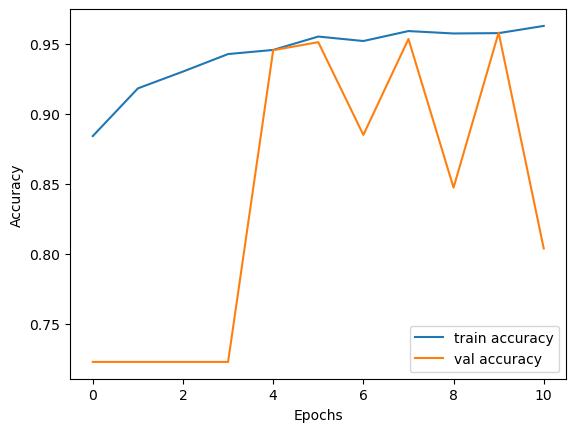

In [45]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [46]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

28/28 [==============================] - 4s 134ms/step - loss: 0.1058 - accuracy: 0.9669
Test Loss: 0.1058
Test Accuracy: 0.9669


In [47]:
predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

28/28 [==============================] - 4s 133ms/step


In [48]:
test_datagen = ImageDataGenerator()  # No augmentation on test data
test_generator = test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


28/28 [==============================] - 4s 145ms/step - loss: 0.1058 - accuracy: 0.9669
Test Loss: 0.1058
Test Accuracy: 0.9669


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
predictions = (model.predict(X_test) > 0.5).astype("int32").flatten()

# Classification report
print(classification_report(y_test, predictions, target_names=['Normal', 'Pneumonia']))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print('Confusion Matrix:\n', conf_matrix)


28/28 [==============================] - 4s 129ms/step
              precision    recall  f1-score   support

      Normal       0.94      0.95      0.94       261
   Pneumonia       0.98      0.98      0.98       615

    accuracy                           0.97       876
   macro avg       0.96      0.96      0.96       876
weighted avg       0.97      0.97      0.97       876

Confusion Matrix:
 [[247  14]
 [ 15 600]]


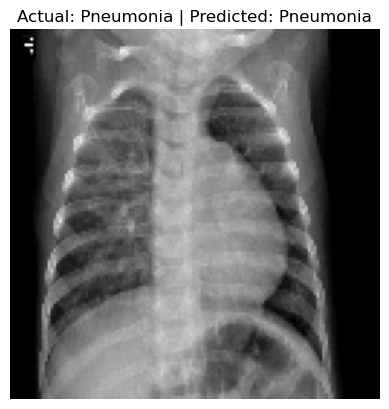

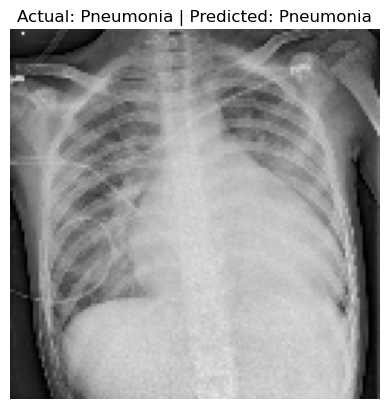

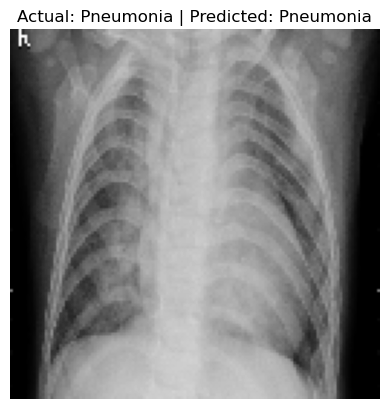

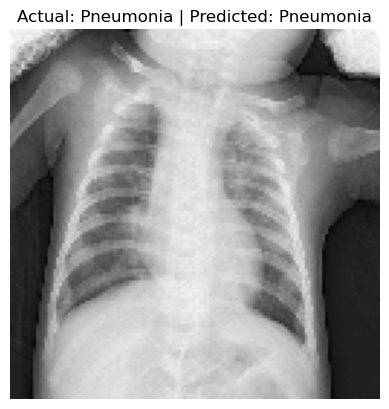

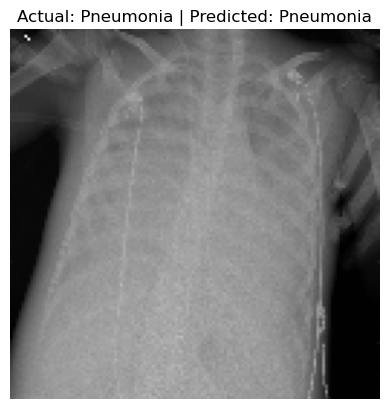

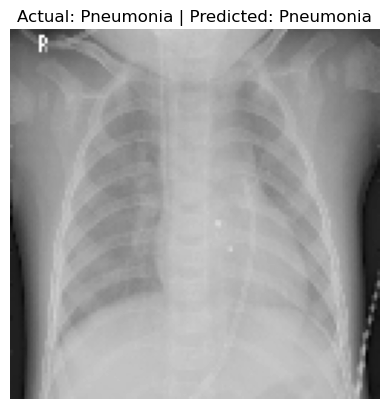

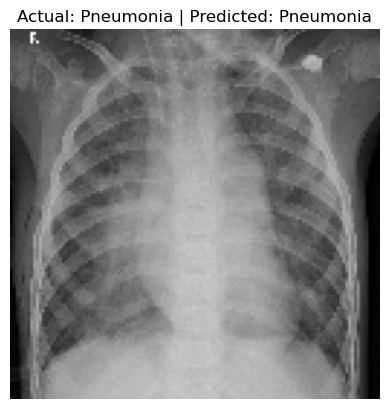

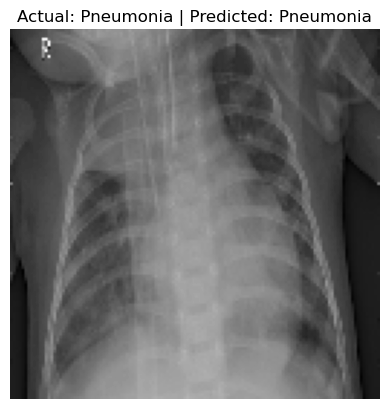

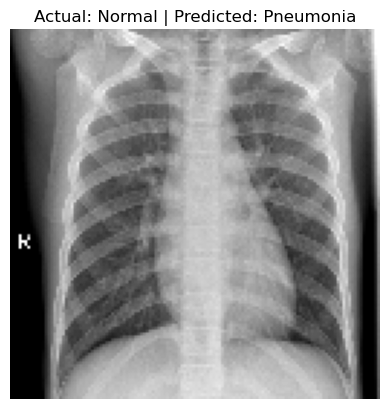

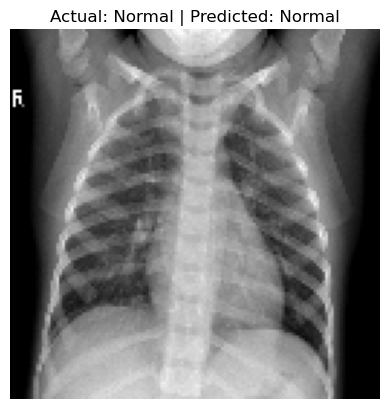

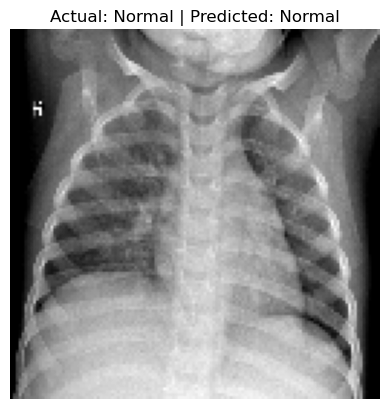

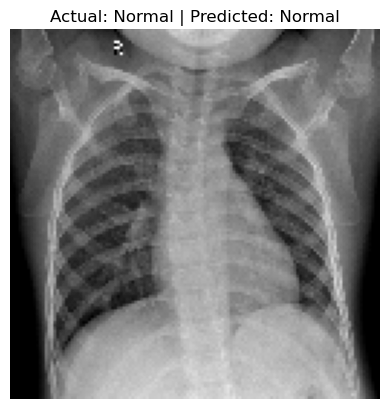

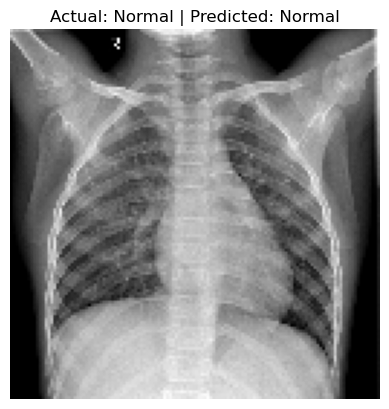

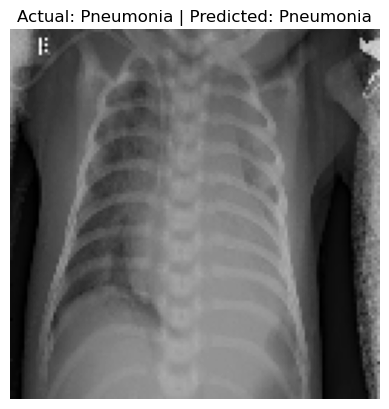

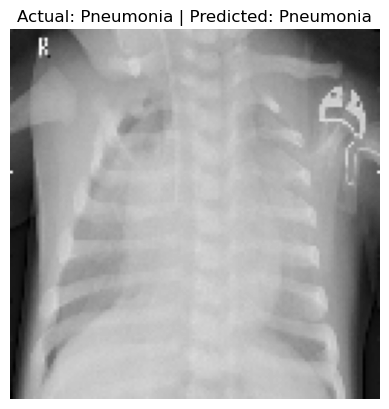

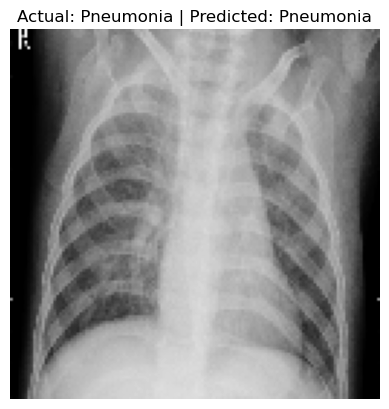

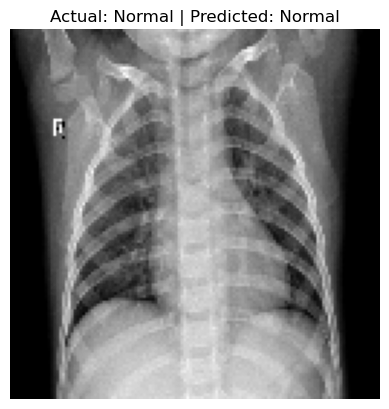

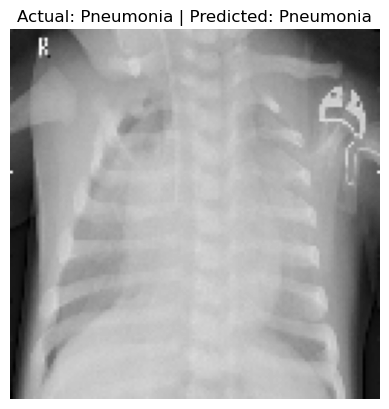

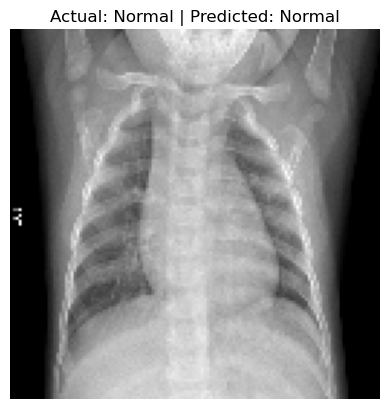

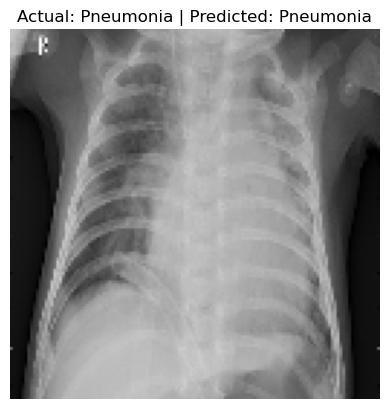

In [50]:
import random

for i in range(20):  # Display 20 random test samples
    idx = random.randint(0, len(X_test) - 1)
    img = X_test[idx].reshape(128, 128)
    plt.imshow(img, cmap='gray')
    plt.title(f"Actual: {'Pneumonia' if y_test[idx] == 1 else 'Normal'} | Predicted: {'Pneumonia' if predictions[idx] == 1 else 'Normal'}")
    plt.axis('off')
    plt.show()


In [51]:
def predict_pneumonia(model, img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128)) / 255.0
    img = img.reshape(1, 128, 128, 1)
    prediction = model.predict(img)
    return 'Pneumonia' if prediction > 0.5 else 'Normal'

In [52]:
img_path = 'C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/NORMAL/NORMAL2-IM-1427-0001.jpeg'
result = predict_pneumonia(model, img_path)
print(f"Prediction for test image: {result}")

1/1 [==============================] - 0s 38ms/step
Prediction for test image: Normal


28/28 [==============================] - 3s 121ms/step


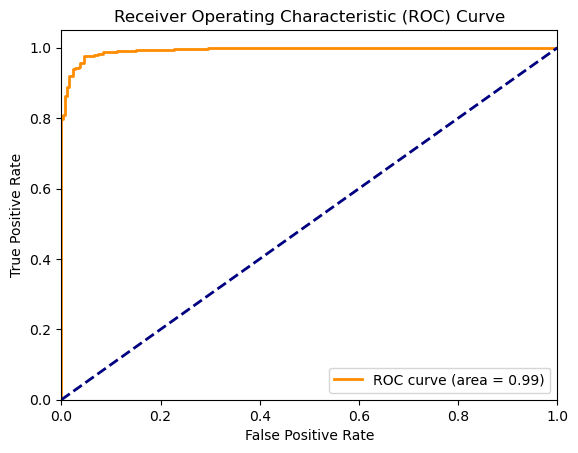

In [53]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = model.predict(X_test).ravel()  # Get probability estimates
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show() 

In [54]:
import cv2
import numpy as np

# Define the prediction function
def predict_pneumonia(model, img_path):
    # Read the image in grayscale (if necessary, change to color if model expects 3 channels)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Check if the image was loaded correctly
    if img is None:
        print(f"Error: Unable to load image at {img_path}")
        return None
    
    # Resize the image to match the input size expected by the model (e.g., 128x128)
    img = cv2.resize(img, (128, 128))

    # Normalize the pixel values to range [0, 1] (since the model expects input in this range)
    img = img / 255.0

    # Reshape the image to have the correct dimensions for the model (1, 128, 128, 1)
    img = img.reshape(1, 128, 128, 1)

    # Predict using the model
    prediction = model.predict(img)

    # Return the prediction result as either "Pneumonia" or "Normal"
    return "Pneumonia" if prediction > 0.5 else "Normal"

In [55]:
i = 'C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/NORMAL/NORMAL2-IM-1427-0001.jpeg'
results = predict_pneumonia(model, i)
print(f"Prediction for real normal image: {results}")

1/1 [==============================] - 0s 33ms/step
Prediction for real normal image: Normal


In [56]:
def load_images_from_directory(directory, img_size=(128, 128)):
    images = []  # List to hold all processed images
    image_paths = []  # List to hold paths for displaying results
    
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        
        # Load image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Verify the image was loaded correctly
        if img is None:
            print(f"Warning: Unable to load image {img_path}. Skipping...")
            continue
        
        # Resize, normalize, and reshape the image
        img = cv2.resize(img, img_size)
        img = img / 255.0
        img = img.reshape(1, img_size[0], img_size[1], 1)
        
        # Append processed image to list
        images.append(img)
        image_paths.append(img_path)
    
    # Stack all images into a single array
    images = np.vstack(images)
    
    return images, image_paths


Test model to random NORMAL images 

In [57]:
# Path to directory containing test images
test_directory = 'C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/NORMAL'

# Load all images from the specified directory
test_images, test_image_paths = load_images_from_directory(test_directory)

# Predict for all images in the batch
if len(test_images) > 0:
    predictions = model.predict(test_images)
    
    # Display results
    for img_path, pred in zip(test_image_paths, predictions):
        result = "Pneumonia" if pred > 0.5 else "Normal"
        print(f"Prediction for {img_path}: {result}")
else:
    print("No images loaded. Please check the directory and file paths.")

1/1 [==============================] - 0s 108ms/step
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/NORMAL\NORMAL2-IM-1427-0001.jpeg: Normal
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/NORMAL\NORMAL2-IM-1430-0001.jpeg: Normal
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/NORMAL\NORMAL2-IM-1431-0001.jpeg: Normal
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/NORMAL\NORMAL2-IM-1436-0001.jpeg: Normal
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/NORMAL\NORMAL2-IM-1437-0001.jpeg: Pneumonia
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/NORMAL\NORMAL2-IM-1438-0001.jpeg: Normal
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/NORMAL\NORMAL2-IM-1440-0001.jpeg: Normal
Prediction for C:/Users/dimit/OneDrive/Desktop/g

Test model to random PNEUMONIA images 

In [58]:
# Path to directory containing test images
test_directoryp = 'C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/PNEUMONIA'

# Load all images from the specified directory
test_imagesp, test_image_pathsp = load_images_from_directory(test_directoryp)

# Predict for all images in the batch
if len(test_imagesp) > 0:
    predictionsp = model.predict(test_imagesp)
    
    # Display results
    for img_pathp, predp in zip(test_image_pathsp, predictionsp):
        resultp = "Pneumonia" if predp > 0.5 else "Normal"
        print(f"Prediction for {img_pathp}: {resultp}")
else:
    print("No images loaded. Please check the directory and file paths.")

1/1 [==============================] - 0s 65ms/step
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/PNEUMONIA\person1946_bacteria_4874.jpeg: Pneumonia
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/PNEUMONIA\person1946_bacteria_4875.jpeg: Pneumonia
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/PNEUMONIA\person1947_bacteria_4876.jpeg: Pneumonia
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/PNEUMONIA\person1949_bacteria_4880.jpeg: Pneumonia
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/PNEUMONIA\person1950_bacteria_4881.jpeg: Pneumonia
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/PNEUMONIA\person1951_bacteria_4882.jpeg: Pneumonia
Prediction for C:/Users/dimit/OneDrive/Desktop/git_projects/Pneumonia-detection/random/PNEUMONIA\person1952_bacteria_488